# **Project: Amazon Product Recommendation System**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem


Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156232 sha256=6868db7affa81598fd0e5001fa18e9c33bdd091f148c73e548160712f5ed2509
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MIT - Python/ratings_Electronics.csv", header = None)## Since there are no column headers in this file.

##**Now, let us see the top ten records of the data.**

In [ ]:
data.head(10)

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


####**As observed from the output of the electronics data file, there are no column heading, we will give each column a heading for better understanding of the data and ease to work with.**
####**We will also drop the last column of the dataset which is a timestamp data, as we are not goig to use this information in our Reccomendation project.**

In [ ]:
data.columns = ["user_id" , "product_id" , "ratings" , "time_stamp"]#adding column headings
data = data.drop('time_stamp', axis = 1) # Dropping timestamp
data.head()

,user_id,product_id,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
data.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = data.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

data = data.loc[ ~ data.user_id.isin(remove_users)] #remove user from data who have given less than 50 ratings.


In [ ]:
# Get the column containing the products
prods = data.product_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_product = []

for product, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_product.append(product)

data_final = data.loc[~ data.product_id.isin(remove_product)] #remove product from the data which have been rated less than 5 number of times.

In [ ]:
# Checking the new dimension of the dataset after removing some users and products.
data_final.count()

user_id       65290
product_id    65290
ratings       65290
dtype: int64

###**Shape of the data**###

In [ ]:
data_final.shape

(65290, 3)

**Now we have 65,290 rows and 3 columns in the data after dropping user and products with less number of counts.**

In [ ]:
data_final.head(10) # Print a few rows of the modified dataset

,user_id,product_id,ratings
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
1485,A19N3S7CBSU6O7,1400501466,5.0
2082,A2ZR3YTMEEIIZ4,1400532655,5.0
2150,A3CLWR1UUZT6TG,1400532655,5.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2228,A1P4XD7IORSEFN,1400532655,4.0


## **Exploratory Data Analysis**

### **Data types**

In [ ]:
data_final.info()# Check for data type and any missing values present and provide observations.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     65290 non-null  object 
 1   product_id  65290 non-null  object 
 2   ratings     65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


###**Observation**###
*   Data set contains two object type columns and 1 float64 type column.
*   There are no missing value in the data.



### **Checking for duplicate rows**

In [ ]:
# Check for duplicate rows in the given dataset.
data_final.duplicated().sum()

0

###**Observation**###

There are no **Duplicate** rows in the dataset.

### **Checking the number of unique users and items in the dataset**

In [ ]:
data_final[["user_id","product_id"]].nunique()

user_id       1540
product_id    5689
dtype: int64

###**Observation**###
*   There are **1540** users on the website.
*   There are **5689** products listed on the website.



###**Check for the number of times each product has been rated and some of the most rated product on the website**###

In [ ]:
data_final.groupby(["product_id"])["product_id"].count().reset_index(name = "count").sort_values("count",ascending = False)#groupby the product and count their number of occurence in dataset.

,product_id,count
4218,B0088CJT4U,206
2316,B003ES5ZUU,184
781,B000N99BBC,167
4126,B007WTAJTO,164
4180,B00829TIEK,149
...,...,...
2182,B00368CDH6,5
2185,B0036AZA6A,5
2186,B0036E8V08,5
2191,B0036QL1JY,5


###**Observation**###
*   Product **B0088CJT4U** has been rated the most by the consumers, i.e. 206 times.
*   Product **B003ES5ZUU** has been rated 184 times.
*   Product **B000N99BBC, B007WTAJTO, B00829TIEK** haven been rated 167, 164,149 times respectively.

*   Product **B00368CDH6, B0036AZA6A, B0036E8V08, B0036QL1JY** are some the products which have been rated least number of times.




### **Checking the rating distribution**

Check the number of times top ratings have been given on the website

In [ ]:
##data_final = data_final.loc[data_final["ratings"] > 1]
print(f"there are {data_final.ratings.nunique()} unique ratings option available.")#Number of Unique ratings that can be given to a product
print("*"*50)
data_final.groupby("ratings")["product_id"].count().reset_index(name = "count").sort_values("ratings",ascending = False)#Number of times each rating has been given to the listings.

there are 5 unique ratings option available.
**************************************************


,ratings,count
4,5.0,36315
3,4.0,18127
2,3.0,6481
1,2.0,2515
0,1.0,1852


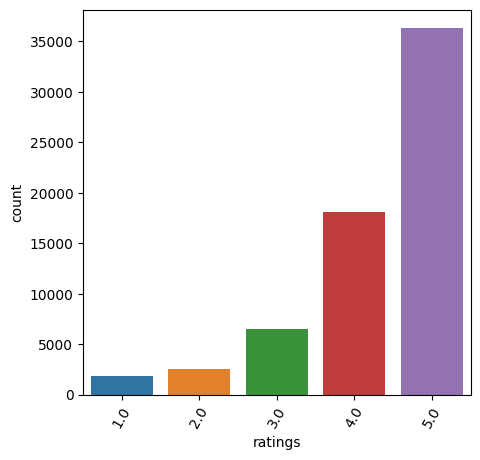

In [ ]:
# Creating the bar plot to provide observations

d = data_final.groupby("ratings")["product_id"].count().reset_index(name = "count").sort_values("ratings",ascending = False)
plt.figure(figsize=(5,5))
sns.barplot(x = 'ratings',
            y = 'count',
            data = d)
plt.xticks(rotation = 60)
# Show the plot
plt.show()

###**Observation**###
Products on the website have received a high rating of "5" a substantial number of times, specifically **36,315** instances.

###**Checking the Most engaged customers on websites**

In [ ]:
# Top 10 users based on the number of ratings
data_final.groupby(["user_id"])["user_id"].count().reset_index(name = "count").sort_values("count",ascending = False)[:10]#groupby the product and count their number of occurence in dataset.

,user_id,count
1287,ADLVFFE4VBT8,295
1086,A3OXHLG6DIBRW8,230
264,A1ODOGXEYECQQ8,217
903,A36K2N527TXXJN,212
462,A25C2M3QF9G7OQ,203
1209,A680RUE1FDO8B,196
431,A22CW0ZHY3NJH8,193
333,A1UQBFCERIP7VJ,193
1508,AWPODHOB4GFWL,184
1051,A3LGT6UZL99IW1,179


###**Observation**###

*  User ADLVFFE4VBT8 stands out as the most active rater on the website, having rated a total of 295 products.

*  However, it's worth noting that there are a substantial 5689 relevant products available on the platform, indicating that this user has yet to explore a significant portion of the product catalog.
   
*  This finding underscores the potential for leveraging the existing data to develop a recommendation system. Such a system could enhance the user experience by suggesting products aligned with their preferences with which they have not interacted before.

*  Furthermore, it could boost user engagement, keeping them involved on the website, and contribute to the overall success of the business.

##**Summary Statistics**

Lets check top 10 maximum rated products and compare them against its mean rating. Later we can build recommendation system while optimising more advertising of these products

In [ ]:
##top 10 products with its mean ratigs.
dp = pd.DataFrame(data_final["product_id"].value_counts()[:10].reset_index())
dp.columns = ["product_id","count"]
dp.set_index("product_id",inplace = True)
print(f"top 10 mostly rated products are: \n")
print(dp)
product = dp.index

##print(product)
print("\n")
print(f"*" *50)

dx = pd.DataFrame([data_final.product_id, data_final.ratings]).T
dx = dx.loc[dx.product_id.isin(product)]
print("\n\ntop 10 mostly rated products with its average ratigs are :\n")
dx.groupby("product_id")["ratings"].mean().reset_index(name="avg_rating").sort_values("avg_rating",ascending=False)



top 10 mostly rated products are: 

            count
product_id       
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
B00829THK0    137
B008DWCRQW    137
B002R5AM7C    128
B004CLYEDC    118
B002SZEOLG    113


**************************************************


top 10 mostly rated products with its average ratigs are :



,product_id,avg_rating
3,B003ES5ZUU,4.864130
0,B000N99BBC,4.772455
5,B007WTAJTO,4.701220
4,B004CLYEDC,4.669492
7,B00829TIEK,4.436242
6,B00829THK0,4.416058
2,B002SZEOLG,4.247788
8,B0088CJT4U,4.218447
1,B002R5AM7C,4.125000
9,B008DWCRQW,4.094891


Lets Plot the graps for product against its average rating.

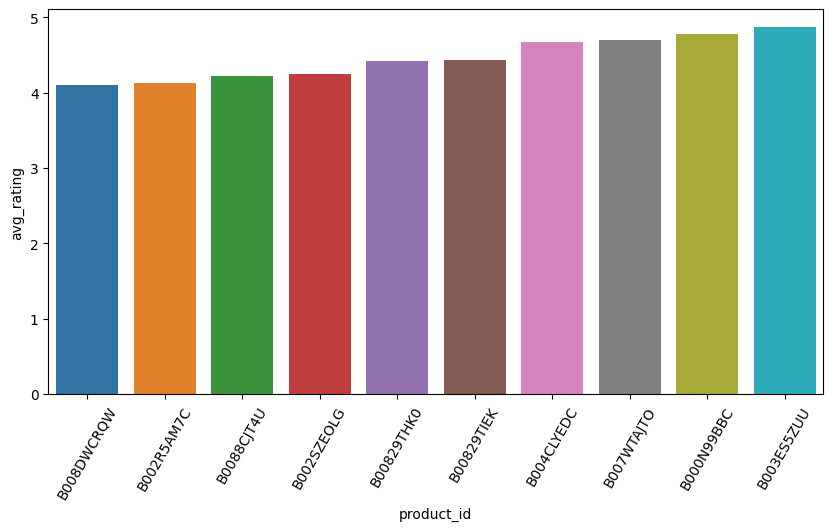

In [ ]:
# Summary statistics of 'rating' variable and provide observations
x = dx.groupby("product_id")["ratings"].mean().reset_index(name="avg_rating").sort_values("avg_rating")

plt.figure(figsize=(10,5))
sns.barplot(x = 'product_id',
            y = 'avg_rating',
            data = x)
plt.xticks(rotation = 60)
# Show the plot
plt.show()


**Observations**



*   The following 10 product_ids represent the most frequently and highly rated products.
*   Among them, Product B003ES5ZUU stands out as exceptionally popular and highly rated. We should gather more information about this product to explore opportunities for introducing similar products and enhancing our advertising efforts to boost revenue



**Now that we have explored and prepared the data, let's build the first recommendation system.**

#**Model 1: Rank Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular songs. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend products to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use a rank-based recommendation system to recommend products to the new user.

To build the rank-based recommendation system, we take count of all the ratings provided to each product and then rank them based on their average ratings.

In [ ]:
# Calculate the average rating for each product
average_rating = data_final.groupby("product_id")["ratings"].mean()

# Calculate the count of ratings for each product
count_rating = data_final.groupby("product_id")["product_id"].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating , 'count':count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('count',ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()



,avg_rating,count
product_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


Now, let's create a function to find the top n sonproductsgs for a recommendation based on the average ratings of products. We can also add a threshold for a minimum number of rating count for a product to be considered for recommendation.

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(data, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = data[data['count'] >= min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get products to recommended.

#### **Recommending top 5 products with 50 minimum interactions based on popularity**####

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### **Recommending top 5 products with 100 minimum interactions based on popularity**####

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

Any New user on the website with no prior browsing and rating history will be recommended there highly popular products filetered out through rank based reccomendation system.

#**Model 2: Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or songs. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering
- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based

## **1- Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating**(3.5) is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Considerations:**

- To compute **precision and recall**, a **threshold rating of 3.5 and k value of 10 can be considered for the recommended and relevant products**.
- The intuition of threshold 3.5 is that if the model predicts that a user will give 3.5 and above rating to the product then that product should be recommended to that user.
- In the present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed above. Hence, the correct performance measure is the F_1 score.


Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the dataset
data = Dataset.load_from_df(data_final[['user_id', 'product_id', 'ratings']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.40, random_state=42)



- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also associated with the surprise package, it is used to find the similar user cluster and also similar products cluster.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# # Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


RMSE: 1.0347
Precision:  0.867
Recall:  0.7
F_1 score:  0.775


**Observations:**
- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of almost 0.70**, which means out of **all the relevant products, 70% are recommended**.
- Intuition of Precision - We are getting a **precision of almost 0.867**, which means **out of all the recommended products, 86.7% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.775**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

 **Observations:**
 - The above output shows that **the actual rating for this user-item pair is 5 and the predicted is 3** by this **user-user-similarity-based baseline model**.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
data_final[data_final.product_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A5JLAU2ARJ0BO" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

In [ ]:
z= data_final[(data_final.product_id == "1400501466") & (data_final.user_id == "A5JLAU2ARJ0BO")]#checking the existence of this particualr user for this particular product.
z

,user_id,product_id,ratings


**Observation-**
User **A5JLAU2ARJ0BO** has not interacted with product **1400501466** in the past.

**Below we are predicting rating for `userId=A5JLAU2ARJ0BO` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product

sim_user_user.predict("A5JLAU2ARJ0BO", "1400501466", verbose = True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 3.67   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=3.6666666666666665, details={'actual_k': 3, 'was_impossible': False})

**Observations**
- If user **A5JLAU2ARJ0BO** interacts with item **1400501466** then the predicted rating that user will give to the item is approx **4** based on the user-user similarity based collaborative filtering.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9796788384994065
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =30.
precision_recall_at_k(sim_user_user_optimized)


RMSE: 0.9763
Precision:  0.845
Recall:  0.705
F_1 score:  0.769


**Observations:**
- Although the RMSE has improved when compared to base user user sim model, the other parameters like Precision, Recall, F-1 score has deteriorated.
- Lets use this optimised model to check and evaluate the new predictions.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A5JLAU2ARJ0BO"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466

sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A5JLAU2ARJ0BO" and productId "1400501466"
sim_user_user_optimized.predict("A5JLAU2ARJ0BO", "1400501466", verbose = True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
data_final["ratings"].mean()# mean rating of the complete dataset.

4.294807780670853

**Observations:**
- The output is not very promising, the new optimised model is not able to find the enough neighbours for the given user in order to predit the ratings.
- the model the assigned overlall data's mean rating as predicted rating since no neighbours were found.
- With the given dataset our baseline model is working better.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[33, 49, 54, 71, 113]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'product_id', values = 'ratings')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A5JLAU2ARJ0BO" with a similarity-based recommendation engine
recommendations = get_recommendations(data_final,"A5JLAU2ARJ0BO", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['product_id', 'predicted_ratings'])

,product_id,predicted_ratings
0,B00006RVPW,5
1,B00077AA5Q,5
2,B000M2TAN4,5
3,B000PO3CTM,5
4,B000Q82PIQ,5


**Observations**:
- To user A5JLAU2ARJ0BO, above given 5 products will be recommeded and their predicted rating being 5.

### **2 - Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:

#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

#KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)


RMSE: 1.0480
Precision:  0.839
Recall:  0.675
F_1 score:  0.748


**observations**
- The baseline model is giving a good F_1 score. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'actual_k': 17, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.294117647058823, details={'actual_k': 17, 'was_impossible': False})

**Observations:**
- The above output shows that **item-item similarity** based model is  making a **good prediction** .
- where the actual rating is 5, the baseline model is predicted 4.29 which is close to the original rating given by this user to this particular product.

Below we are **predicting rating for the `userId = A5JLAU2ARJ0BO` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A5JLAU2ARJ0BO", "1400501466", verbose=True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 4.33   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=4.333333333333333, details={'actual_k': 3, 'was_impossible': False})

**Observations**

- baseline item-item similarity-based algorithm is predicting a rating of 4.33  **user-product pair**.
- Apparantely the baseline item-item similarity-based algorithm is giving good results.

### **Improving item item similarity-based recommendation system by tuning its hyper-parameters**
Below we will be tuning hyperparameters for the KNNBasic algorithms. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'msd','pearson',"pearson_baseline"],
                              'user_based': [False], "min_support":[2,4]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.983953024439623
{'k': 10, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False, 'min_support': 2}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:

# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False, "min_support":4}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=10, min_k=6, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9841
Precision:  0.831
Recall:  0.699
F_1 score:  0.759


**Observations**
- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value with tuning. Hence the tuned model is doing better than the earlier one.
- Let's us now predict **ratings for user with who has interacted with the item** with the **optimized model** and compare the rating with the original rating given.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A5JLAU2ARJ0BO"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A5JLAU2ARJ0BO", "1400501466", verbose=True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
- The above output shows that **Optimised item-item similarity** based model is not making a **good prediction** since there are not enough neighbour spotted.
- where the actual rating is 5, the optimised model has predicted 4.29 the average of overall data..
- Apparently the base line item-item based similarity model is working beter.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item.get_neighbors(0, k=5)

[117, 144, 151, 156, 157]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(data_final, "A1A5KUIIIHFF4U", 5, sim_item_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['product_id', 'predicted_ratings'])

,product_id,predicted_ratings
0,B00000J1V5,5
1,B00004SABB,5
2,B00004W3ZQ,5
3,B000065BP9,5
4,B00006HSYC,5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:

# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k =10.
precision_recall_at_k(svd)

RMSE: 0.9032
Precision:  0.87
Recall:  0.708
F_1 score:  0.781


**Observations**

- The baseline model with the algorithm is giving a nice F-1 score (almost **78.1%**). It indicates a good performance by the model. The RMSE of the model is 0.9032.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.084585882575799, details={'was_impossible': False})

**Observations**
- As we can see - **the actual rating** for this user-product pair is 5 and the predicted rating is **4.08** by this matrix **factorization-based baseline model**.
- It seems like we have under-estimated the product rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV

**Below we are predicting rating for the `userId = "A5JLAU2ARJ0BO"` and `productId = "1400501466"`.**

In [ ]:
svd.predict("A5JLAU2ARJ0BO", "1400501466", verbose=True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 3.34   {'was_impossible': False}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=3.3379119185240045, details={'was_impossible': False})

**Observations**
- We can see that the **estimated ratingt** for this **user-product pair** is 3.34 based on this **matrix factorization based baseline model**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

In SVD, play_count is predicted as -

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

# Performing 3-fold gridsearch cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])


0.8977060112401594
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE

# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Training the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10 using precision_recall_at_k function.
precision_recall_at_k(svd_optimized)

RMSE: 0.8942
Precision:  0.876
Recall:  0.706
F_1 score:  0.782


**Observations**
- We can see from above that the **tuned model** is showing a similar  F_1 score and and lower RMSE in the model. Hence the tuned model is notndoing any better than the earlier model.

But lets see if there is any improvement in the rating prediction accuracy.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.118901367196172, details={'was_impossible': False})

- Here the predicted rating is **4.12** for a product whose actual rating is **5**.

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A5JLAU2ARJ0BO", "1400501466", verbose=True)

user: A5JLAU2ARJ0BO item: 1400501466 r_ui = None   est = 3.46   {'was_impossible': False}


Prediction(uid='A5JLAU2ARJ0BO', iid='1400501466', r_ui=None, est=3.456161547174601, details={'was_impossible': False})

- For an unseen product the ratings given by the optimized model is **3.46**.

**Predicted top 5 products for userId=A5JLAU2ARJ0BO with svd_optimized based recommendation system**

In [ ]:
# Getting top 5 recommendations for user_id A5JLAU2ARJ0BO using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(data_final, "A5JLAU2ARJ0BO", 5, svd_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(svd_recommendations, columns=['product_id', 'predicted_ratings'])

,product_id,predicted_ratings
0,B0017H4G0A,4.530779
1,B001QUA6RA,4.496185
2,B0052SCU8U,4.492554
3,B001FA09WI,4.487418
4,B0010Y414Q,4.485787


### **Conclusion**

In this case study, we built recommendation systems using five different algorithms. They are as follows:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- Model-based (matrix factorization) collaborative filtering  

We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been demonstrated. For these algorithms **grid search cross-validation is used to find the best working model**, and using that the **corresponding predictions are made**.


#### **Proposal for the final solution design:**

We will use the Model Based Collaborative Filtering - Matrix Factorization  collaborative filtering baseline recommendation system as final solution since it is more robust and gives a high and best F_1 score amongst all other models.